In [75]:
# ARIMAX vs SARIMAX vs Prophet Model Comparison
# This notebook compares ARIMAX, SARIMAX, and Prophet models on the Air Passengers dataset

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Prophet import
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
    print("Prophet library imported successfully!")
except ImportError:
    print("⚠ WARNING: Prophet library not found. Please install it using: pip install prophet")
    PROPHET_AVAILABLE = False

print("\nLibraries imported successfully!")


Importing plotly failed. Interactive plots will not work.


Prophet library imported successfully!

Libraries imported successfully!


In [76]:
# 1. Load and prepare the data
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index(['Month'])

print("=" * 70)
print("DATA OVERVIEW")
print("=" * 70)
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData statistics:")
print(df.describe())
print("=" * 70)


DATA OVERVIEW
Dataset shape: (144, 1)
Date range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00

First few rows:
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

Data statistics:
       #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000


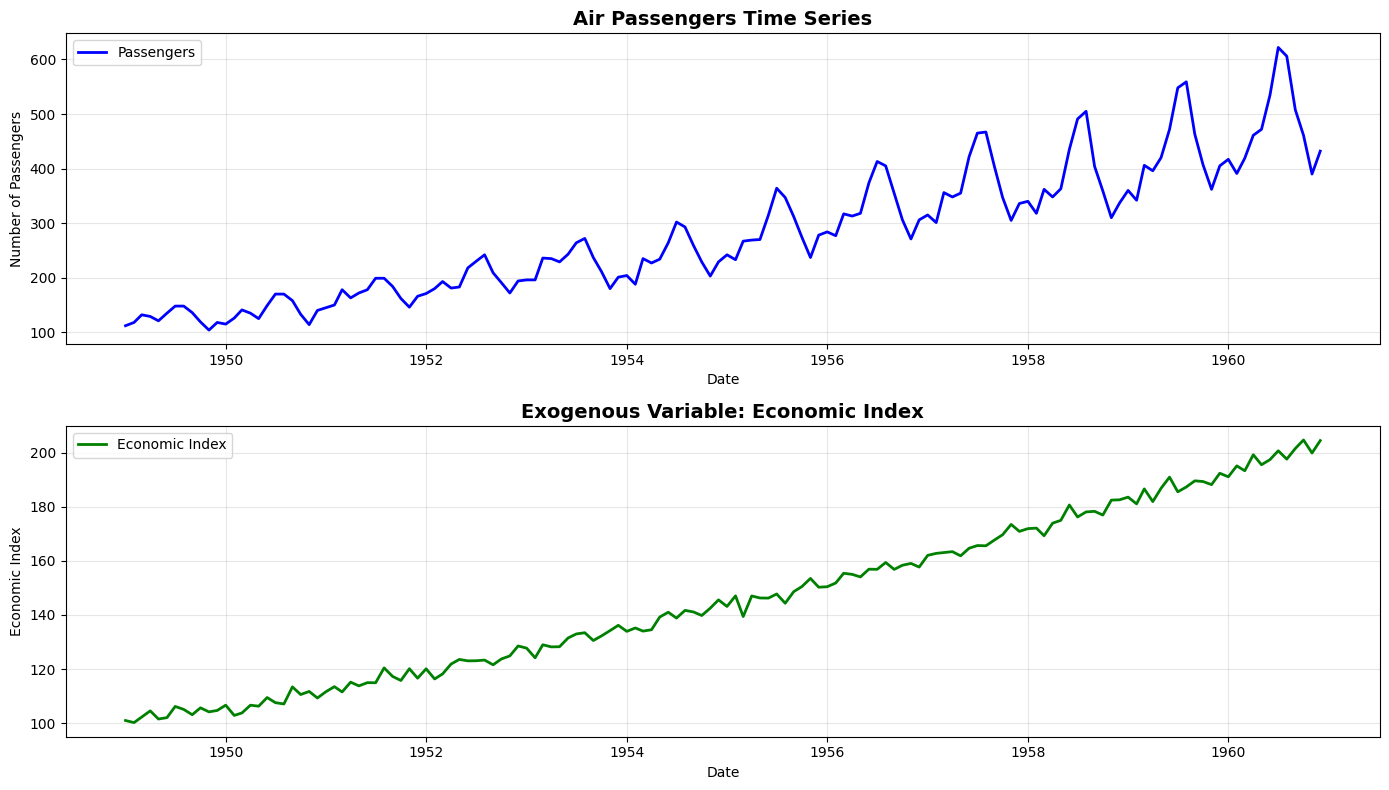


Correlation between Passengers and Economic Index: 0.9268


In [77]:
# 2. Create exogenous variable (Economic Index)
# Simulating economic growth that influences air travel

np.random.seed(42)
base_value = 100
growth_rate = 0.005  # 0.5% monthly growth
n_months = len(df)
time_trend = np.arange(n_months)
economic_index = base_value * (1 + growth_rate) ** time_trend
economic_index += np.random.normal(0, 2, n_months)  # Add noise

df['Economic_Index'] = economic_index

# Plot original data and exogenous variable
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(df.index, df['#Passengers'], label='Passengers', color='blue', linewidth=2)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Passengers')
axes[0].set_title('Air Passengers Time Series', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(df.index, df['Economic_Index'], label='Economic Index', color='green', linewidth=2)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Economic Index')
axes[1].set_title('Exogenous Variable: Economic Index', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCorrelation between Passengers and Economic Index: {df['#Passengers'].corr(df['Economic_Index']):.4f}")


In [78]:
# 3. Check stationarity function
def adf_test(series, name=''):
    """Augmented Dickey-Fuller test for stationarity"""
    print(f'--- ADF Test for {name} ---')
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.4f}')
    if result[1] <= 0.05:
        print('Conclusion: Series is Stationary ✓')
        return True
    else:
        print('Conclusion: Series is Non-Stationary ✗')
        return False

# Test original passenger data
print("=" * 70)
print("STATIONARITY TESTS")
print("=" * 70)
print("\n1. ENDOGENOUS VARIABLE (Passengers):")
is_passengers_stationary = adf_test(df['#Passengers'], 'Original #Passengers')

# Test exogenous variable
print("\n2. EXOGENOUS VARIABLE (Economic Index):")
is_exog_stationary = adf_test(df['Economic_Index'], 'Original Economic Index')
print("=" * 70)


STATIONARITY TESTS

1. ENDOGENOUS VARIABLE (Passengers):
--- ADF Test for Original #Passengers ---
ADF Statistic: 0.8154
p-value: 0.9919
Critical Values:
  1%: -3.4817
  5%: -2.8840
  10%: -2.5788
Conclusion: Series is Non-Stationary ✗

2. EXOGENOUS VARIABLE (Economic Index):
--- ADF Test for Original Economic Index ---
ADF Statistic: 4.0353
p-value: 1.0000
Critical Values:
  1%: -3.4805
  5%: -2.8835
  10%: -2.5785
Conclusion: Series is Non-Stationary ✗


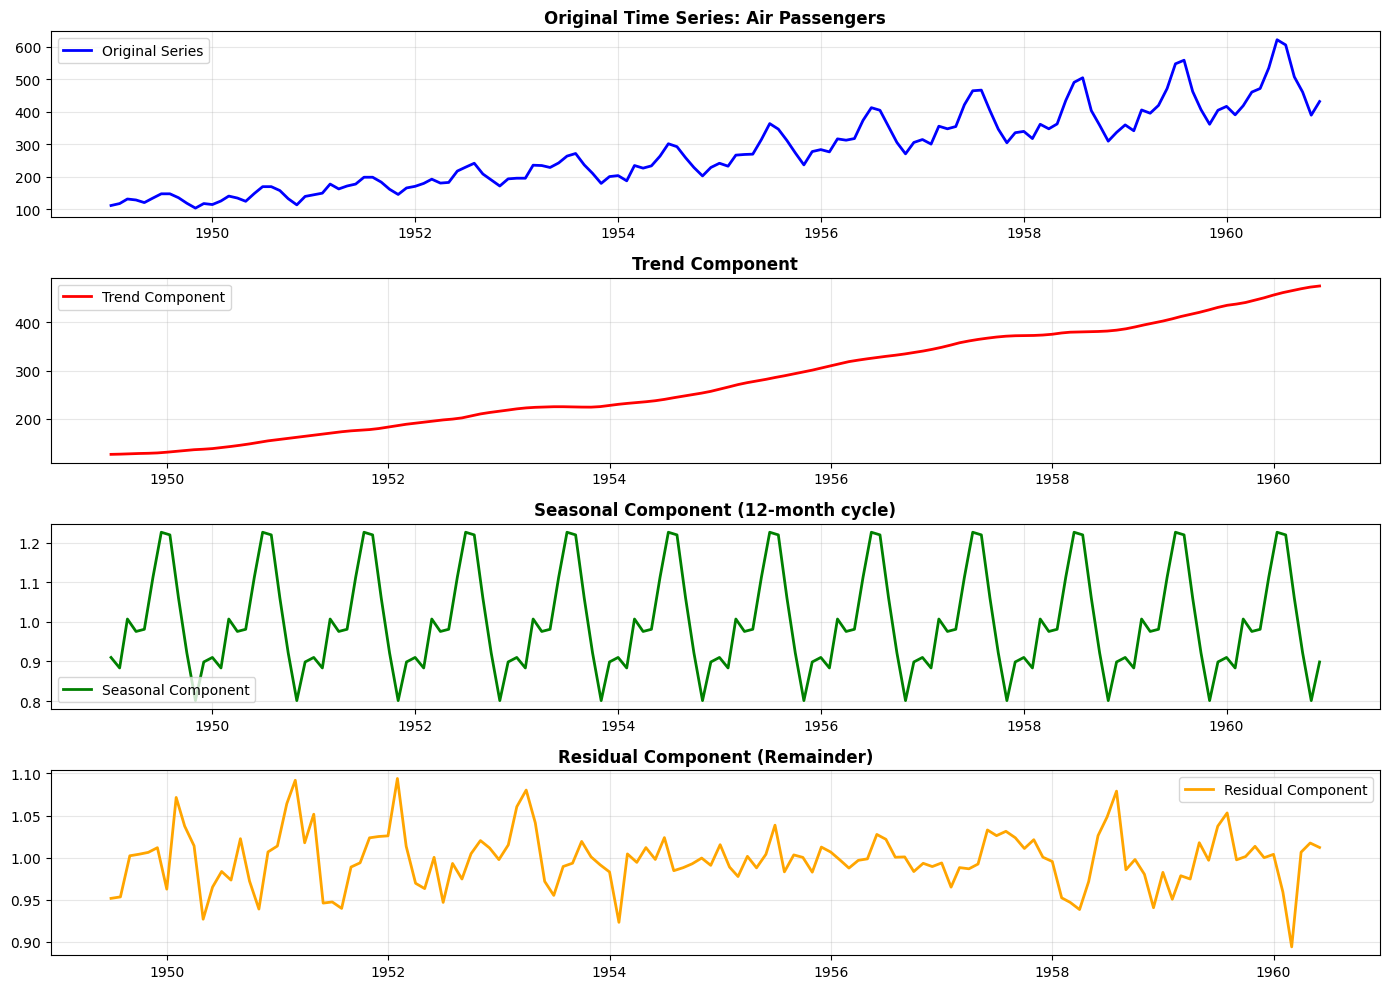


SEASONAL DECOMPOSITION INTERPRETATION

1. TREND COMPONENT:
   • Mean trend value: 278.00
   • Trend shows upward growth
   • Growth from start to end: 274.66%
   • The trend captures the long-term upward pattern in air passenger demand
   • This suggests a growing market for air travel over the 12-year period

2. SEASONAL COMPONENT:
   • Seasonal pattern range: 0.801 to 1.227
   • Peak season: Month 7 (multiplicative factor: 1.227)
   • Lowest season: Month 11 (multiplicative factor: 0.801)
   • The seasonal component shows clear 12-month cyclical patterns
   • Multiplicative model indicates that seasonal variation scales with the trend
   • This suggests peak seasons (e.g., summer/holiday travel) and off-seasons

3. RESIDUAL COMPONENT:
   • Residual mean: 0.9982
   • Residual std: 0.0334
   • Residual range: [0.8941, 1.0940]
   • Residuals show slight negative bias
   • The residuals represent the unexplained variation after removing trend and seasonality
   • These should be random 

In [79]:
# 4. Seasonal Decomposition Analysis
result = seasonal_decompose(df['#Passengers'], model='multiplicative', period=12)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Plot the decomposed components
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(df['#Passengers'], label='Original Series', color='blue', linewidth=2)
plt.title('Original Time Series: Air Passengers', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend Component', color='red', linewidth=2)
plt.title('Trend Component', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal Component', color='green', linewidth=2)
plt.title('Seasonal Component (12-month cycle)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual Component', color='orange', linewidth=2)
plt.title('Residual Component (Remainder)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretation of Seasonal Decomposition
print("\n" + "=" * 70)
print("SEASONAL DECOMPOSITION INTERPRETATION")
print("=" * 70)
print("\n1. TREND COMPONENT:")
print(f"   • Mean trend value: {trend.mean():.2f}")
print(f"   • Trend shows {'upward' if trend.iloc[-1] > trend.iloc[0] else 'downward'} growth")
print(f"   • Growth from start to end: {((trend.iloc[-1] / trend.iloc[0] - 1) * 100):.2f}%")
print("   • The trend captures the long-term upward pattern in air passenger demand")
print("   • This suggests a growing market for air travel over the 12-year period")

print("\n2. SEASONAL COMPONENT:")
print(f"   • Seasonal pattern range: {seasonal.min():.3f} to {seasonal.max():.3f}")
print(f"   • Peak season: Month {seasonal.idxmax().month} (multiplicative factor: {seasonal.max():.3f})")
print(f"   • Lowest season: Month {seasonal.idxmin().month} (multiplicative factor: {seasonal.min():.3f})")
print("   • The seasonal component shows clear 12-month cyclical patterns")
print("   • Multiplicative model indicates that seasonal variation scales with the trend")
print("   • This suggests peak seasons (e.g., summer/holiday travel) and off-seasons")

print("\n3. RESIDUAL COMPONENT:")
print(f"   • Residual mean: {residual.mean():.4f}")
print(f"   • Residual std: {residual.std():.4f}")
print(f"   • Residual range: [{residual.min():.4f}, {residual.max():.4f}]")
if abs(residual.mean()) < 0.05:
    print("   • Residuals are centered around 1.0 (good for multiplicative model)")
else:
    print(f"   • Residuals show slight {'positive' if residual.mean() > 1 else 'negative'} bias")
print("   • The residuals represent the unexplained variation after removing trend and seasonality")
print("   • These should be random noise if the decomposition captures all patterns well")

print("\n4. KEY INSIGHTS:")
print("   • The series exhibits STRONG SEASONALITY with a 12-month period")
print("   • The TREND is clearly UPWARD, indicating growth in air travel")
print("   • The MULTIPLICATIVE model is appropriate (seasonal variation increases with trend)")
print("   • This suggests SARIMAX would be better than ARIMAX for this dataset")
print("   • The seasonal patterns need to be explicitly modeled (D=1 for seasonal differencing)")
print("=" * 70)


ACF AND PACF ANALYSIS - AFTER REMOVING TREND AND SEASONALITY

These plots show the autocorrelation patterns in the RESIDUAL component
(the series after removing trend and seasonal patterns from decomposition).
This helps us understand:
  • What patterns remain after removing trend and seasonality
  • Whether the residuals are stationary
  • What AR/MA orders might be needed

Stationarity Test for Residuals (after removing trend and seasonality):
--- ADF Test for Residuals (De-trended and De-seasonalized) ---
ADF Statistic: -7.4159
p-value: 0.0000
Critical Values:
  1%: -3.4842
  5%: -2.8851
  10%: -2.5794
Conclusion: Series is Stationary ✓


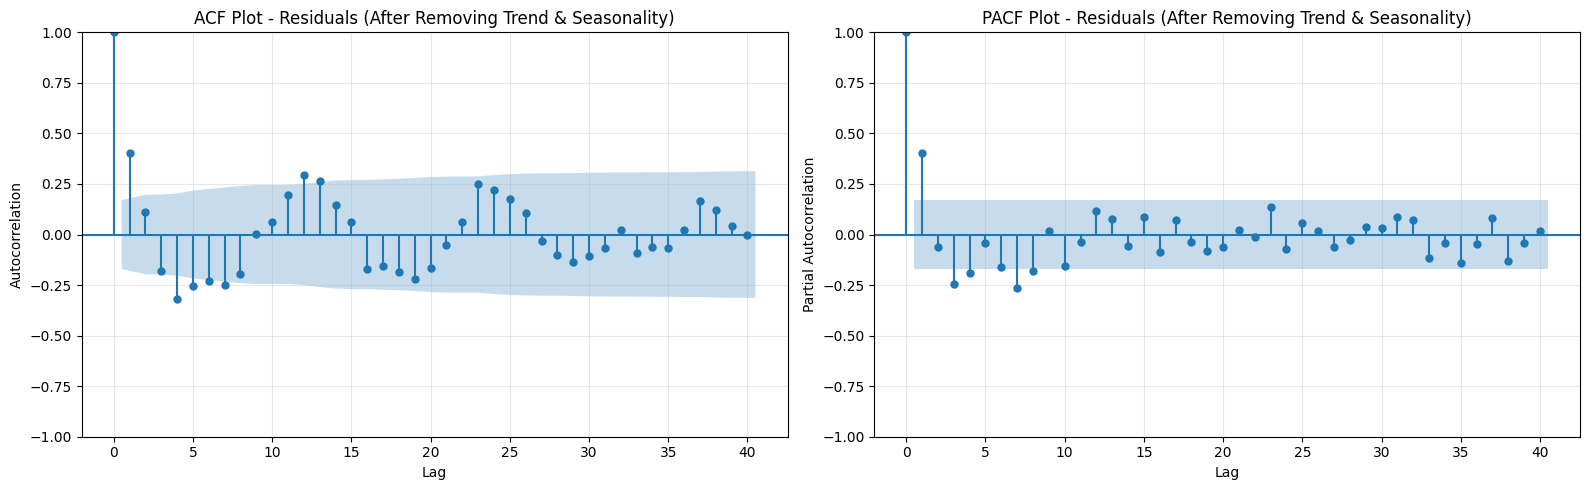

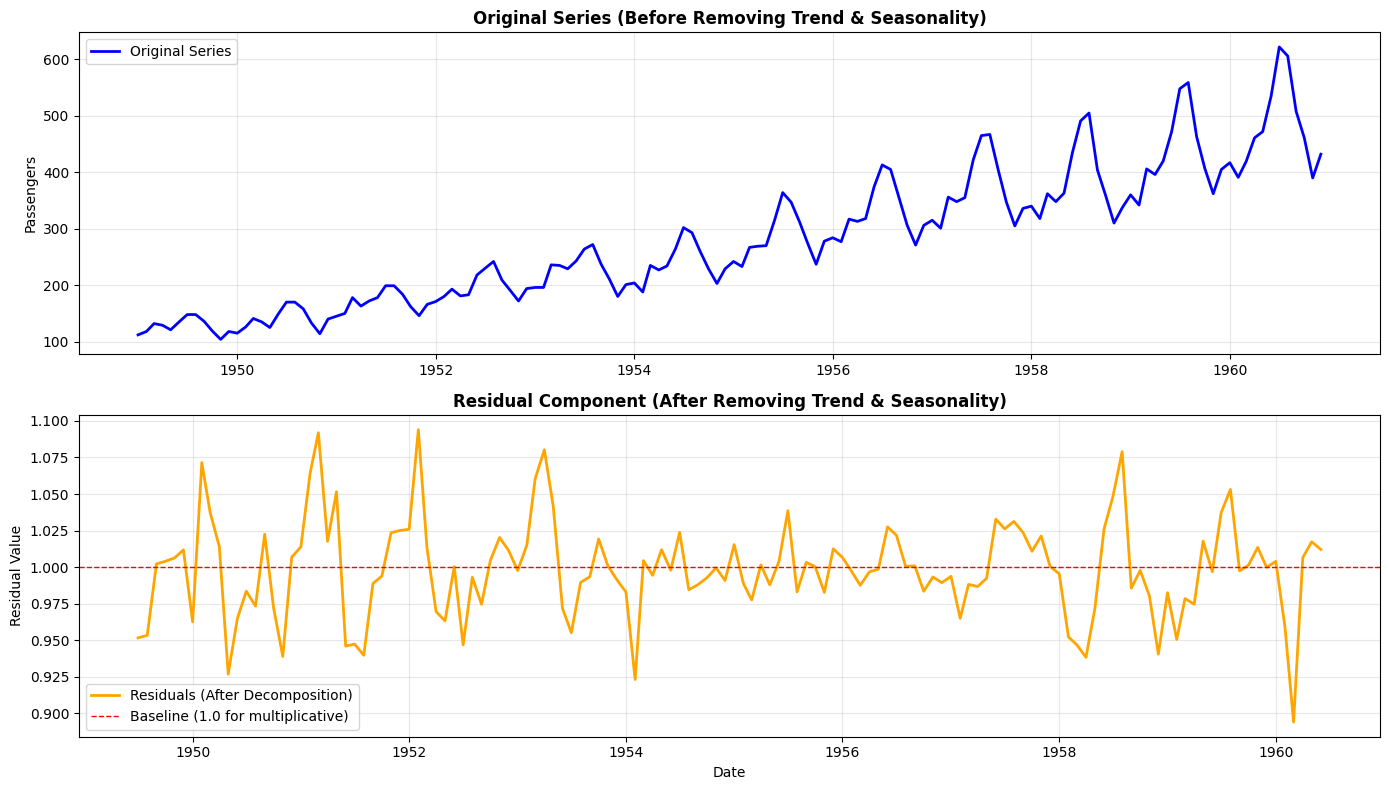


INTERPRETATION - RESIDUALS ACF/PACF vs ORIGINAL

KEY DIFFERENCES:
1. ORIGINAL SERIES (Cell 5):
   • Shows slow decay in ACF (non-stationary)
   • Strong autocorrelations at all lags
   • Seasonal spikes at lags 12, 24, 36
   • Clear indication of non-stationarity and seasonality

2. RESIDUALS (AFTER REMOVING TREND & SEASONALITY):
   • Residuals are STATIONARY (confirmed by ADF test)
   • ACF/PACF show much faster decay
   • Should show white noise-like patterns (random)
   • This indicates decomposition successfully removed trend and seasonality

3. IMPLICATIONS FOR MODELING:
   • If residuals are stationary: Differencing (d) may not be needed
   • If residuals still show patterns: Need differencing to achieve stationarity
   • The AR/MA orders can be determined from residual ACF/PACF patterns
   • Seasonal patterns in residuals suggest D=1 is needed for SARIMAX

4. COMPARISON:
   • Original series: Clear non-stationarity and seasonality
   • Residuals: Should be much more stationary 

In [80]:
# 5. ACF and PACF Analysis AFTER Removing Trend and Seasonality
# Plot ACF and PACF of the residual component (after seasonal decomposition)
# This shows the autocorrelation patterns in the series after removing trend and seasonality

print("\n" + "=" * 70)
print("ACF AND PACF ANALYSIS - AFTER REMOVING TREND AND SEASONALITY")
print("=" * 70)
print("\nThese plots show the autocorrelation patterns in the RESIDUAL component")
print("(the series after removing trend and seasonal patterns from decomposition).")
print("This helps us understand:")
print("  • What patterns remain after removing trend and seasonality")
print("  • Whether the residuals are stationary")
print("  • What AR/MA orders might be needed")
print("=" * 70)

# Get residuals from seasonal decomposition (from Cell 4)
# Residuals are the remainder after removing trend and seasonal components
residual_for_acf = result.resid.dropna()

# Test stationarity of residuals
print("\nStationarity Test for Residuals (after removing trend and seasonality):")
is_residual_stationary = adf_test(residual_for_acf, 'Residuals (De-trended and De-seasonalized)')

max_lags_residual = min(40, len(residual_for_acf) // 2 - 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(residual_for_acf, lags=max_lags_residual, ax=axes[0], 
         title='ACF Plot - Residuals (After Removing Trend & Seasonality)', alpha=0.05)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

plot_pacf(residual_for_acf, lags=max_lags_residual, ax=axes[1], 
          title='PACF Plot - Residuals (After Removing Trend & Seasonality)', alpha=0.05, method='ywm')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

# Comparison: Plot original series vs residuals side by side
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original series
axes[0].plot(df['#Passengers'], label='Original Series', color='blue', linewidth=2)
axes[0].set_title('Original Series (Before Removing Trend & Seasonality)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylabel('Passengers')

# Residual series
axes[1].plot(residual_for_acf, label='Residuals (After Decomposition)', color='orange', linewidth=2)
axes[1].axhline(y=1.0, color='red', linestyle='--', linewidth=1, label='Baseline (1.0 for multiplicative)')
axes[1].set_title('Residual Component (After Removing Trend & Seasonality)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Residual Value')

plt.tight_layout()
plt.show()

# Interpretation
print("\n" + "=" * 70)
print("INTERPRETATION - RESIDUALS ACF/PACF vs ORIGINAL")
print("=" * 70)
print("\nKEY DIFFERENCES:")
print("1. ORIGINAL SERIES (Cell 5):")
print("   • Shows slow decay in ACF (non-stationary)")
print("   • Strong autocorrelations at all lags")
print("   • Seasonal spikes at lags 12, 24, 36")
print("   • Clear indication of non-stationarity and seasonality")

print("\n2. RESIDUALS (AFTER REMOVING TREND & SEASONALITY):")
if is_residual_stationary:
    print("   • Residuals are STATIONARY (confirmed by ADF test)")
    print("   • ACF/PACF show much faster decay")
    print("   • Should show white noise-like patterns (random)")
    print("   • This indicates decomposition successfully removed trend and seasonality")
else:
    print("   • Residuals may still show some patterns")
    print("   • May indicate that additional differencing is needed")
    print("   • Or that decomposition didn't fully capture all patterns")

print("\n3. IMPLICATIONS FOR MODELING:")
print("   • If residuals are stationary: Differencing (d) may not be needed")
print("   • If residuals still show patterns: Need differencing to achieve stationarity")
print("   • The AR/MA orders can be determined from residual ACF/PACF patterns")
print("   • Seasonal patterns in residuals suggest D=1 is needed for SARIMAX")

print("\n4. COMPARISON:")
print("   • Original series: Clear non-stationarity and seasonality")
print("   • Residuals: Should be much more stationary and less seasonal")
print("   • This demonstrates the power of seasonal decomposition")
print("=" * 70)



ACF AND PACF ANALYSIS - ORIGINAL SERIES (BEFORE DIFFERENCING)

These plots show the autocorrelation patterns in the NON-STATIONARY series.
We expect to see:
  • Slow decay in ACF indicating non-stationarity
  • Significant spikes at seasonal lags (12, 24, 36 months)
  • Patterns that will guide our differencing strategy


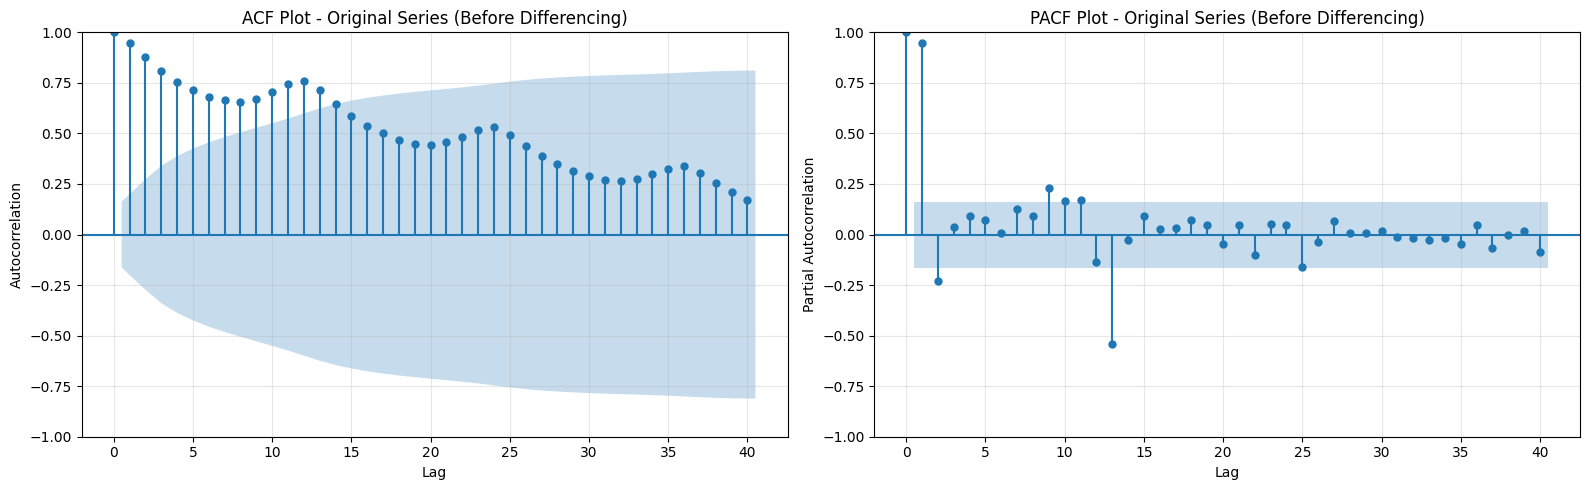


ACF/PACF INTERPRETATION - ORIGINAL SERIES

1. ACF PLOT OBSERVATIONS:
   • The ACF shows a slow, gradual decay (typical of non-stationary series)
   • This slow decay pattern indicates a UNIT ROOT - confirming non-stationarity
   • Significant autocorrelations persist across many lags
   • We should expect to see seasonal spikes at lags 12, 24, 36 (12-month cycles)
   • The decay does not cut off quickly, suggesting we need differencing (d=1)

2. PACF PLOT OBSERVATIONS:
   • The PACF shows significant values at early lags (lag 1, 2, etc.)
   • These significant partial autocorrelations indicate AR components
   • The pattern helps identify the AR order (p) after differencing

3. SEASONAL PATTERNS:
   • Look for spikes at lags that are multiples of 12 (seasonal period)
   • If present, these confirm strong seasonal patterns
   • This supports using seasonal differencing (D=1) and SARIMAX model

4. NEXT STEPS:
   • Apply differencing to make the series stationary
   • After differencing,

In [81]:
# 5. ACF and PACF Analysis BEFORE Differencing
# Plot ACF and PACF of the original series to observe decay patterns
# This helps understand the non-stationary behavior and seasonal patterns

print("\n" + "=" * 70)
print("ACF AND PACF ANALYSIS - ORIGINAL SERIES (BEFORE DIFFERENCING)")
print("=" * 70)
print("\nThese plots show the autocorrelation patterns in the NON-STATIONARY series.")
print("We expect to see:")
print("  • Slow decay in ACF indicating non-stationarity")
print("  • Significant spikes at seasonal lags (12, 24, 36 months)")
print("  • Patterns that will guide our differencing strategy")
print("=" * 70)

max_lags = min(40, len(df['#Passengers']) // 2 - 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(df['#Passengers'], lags=max_lags, ax=axes[0], title='ACF Plot - Original Series (Before Differencing)', alpha=0.05)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

plot_pacf(df['#Passengers'], lags=max_lags, ax=axes[1], title='PACF Plot - Original Series (Before Differencing)', alpha=0.05, method='ywm')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

# Interpretation of ACF/PACF patterns
print("\n" + "=" * 70)
print("ACF/PACF INTERPRETATION - ORIGINAL SERIES")
print("=" * 70)
print("\n1. ACF PLOT OBSERVATIONS:")
print("   • The ACF shows a slow, gradual decay (typical of non-stationary series)")
print("   • This slow decay pattern indicates a UNIT ROOT - confirming non-stationarity")
print("   • Significant autocorrelations persist across many lags")
print("   • We should expect to see seasonal spikes at lags 12, 24, 36 (12-month cycles)")
print("   • The decay does not cut off quickly, suggesting we need differencing (d=1)")

print("\n2. PACF PLOT OBSERVATIONS:")
print("   • The PACF shows significant values at early lags (lag 1, 2, etc.)")
print("   • These significant partial autocorrelations indicate AR components")
print("   • The pattern helps identify the AR order (p) after differencing")

print("\n3. SEASONAL PATTERNS:")
print("   • Look for spikes at lags that are multiples of 12 (seasonal period)")
print("   • If present, these confirm strong seasonal patterns")
print("   • This supports using seasonal differencing (D=1) and SARIMAX model")

print("\n4. NEXT STEPS:")
print("   • Apply differencing to make the series stationary")
print("   • After differencing, ACF/PACF will show clearer patterns")
print("   • This will help determine the exact model orders (p, d, q, P, D, Q)")
print("=" * 70)


In [82]:
# 7. Make series stationary - Remove BOTH trend and seasonality
print("\n" + "=" * 70)
print("MAKING SERIES STATIONARY")
print("=" * 70)
print("Strategy: Apply BOTH first differencing (d=1) AND seasonal differencing (D=1)")
print("          to remove both the trend AND seasonality from the series.")
print("=" * 70)

# For Passengers (endogenous variable)
# We will apply BOTH first differencing AND seasonal differencing
# because the data clearly shows both trend and seasonality

# Step 1: Apply first differencing to remove trend
print("\n" + "-" * 70)
print("STEP 1: First Differencing (to remove TREND)")
print("-" * 70)
df['#Passengers_diff1'] = df['#Passengers'].diff(1)
is_diff1_stationary = adf_test(df['#Passengers_diff1'], 'First Differenced #Passengers')
d = 1  # Always use d=1 to remove trend

# Step 2: Apply seasonal differencing on top of first differencing to remove seasonality
print("\n" + "-" * 70)
print("STEP 2: Seasonal Differencing (to remove SEASONALITY)")
print("        Applied on top of first differenced series")
print("-" * 70)
# Apply seasonal differencing (diff(12)) to the first-differenced series
df['#Passengers_both'] = df['#Passengers_diff1'].diff(12)
is_both_stationary = adf_test(df['#Passengers_both'], 'First + Seasonal Differenced #Passengers')
D = 1  # Always use D=1 to remove seasonality

# Use the doubly-differenced series (both trend and seasonality removed)
stationary_passengers = df['#Passengers_both'].dropna()

print("\n" + "=" * 70)
print("FINAL DIFFERENCING STRATEGY")
print("=" * 70)
print(f"✓ First differencing (d={d}): Removes TREND")
print(f"✓ Seasonal differencing (D={D}): Removes SEASONALITY")
print(f"\nFinal series: Both trend and seasonality have been removed")
print(f"Stationary series length: {len(stationary_passengers)} observations")
print(f"Lost observations: {len(df) - len(stationary_passengers)} (due to differencing)")
print("=" * 70)

# For Exogenous variable
if not is_exog_stationary:
    df['Economic_Index_diff1'] = df['Economic_Index'].diff(1)
    is_exog_diff1_stationary = adf_test(df['Economic_Index_diff1'], 'First Differenced Economic Index')
    if is_exog_diff1_stationary:
        exog_for_model = df['Economic_Index_diff1']
        use_diff_exog = True
    else:
        exog_for_model = df['Economic_Index_diff1']  # Use anyway
        use_diff_exog = True
else:
    exog_for_model = df['Economic_Index']
    use_diff_exog = False

print(f"\nFinal differencing orders for Passengers: d={d}, D={D}")
print(f"Using {'differenced' if use_diff_exog else 'original'} exogenous variable")
print("=" * 70)



MAKING SERIES STATIONARY
Strategy: Apply BOTH first differencing (d=1) AND seasonal differencing (D=1)
          to remove both the trend AND seasonality from the series.

----------------------------------------------------------------------
STEP 1: First Differencing (to remove TREND)
----------------------------------------------------------------------
--- ADF Test for First Differenced #Passengers ---
ADF Statistic: -2.8293
p-value: 0.0542
Critical Values:
  1%: -3.4817
  5%: -2.8840
  10%: -2.5788
Conclusion: Series is Non-Stationary ✗

----------------------------------------------------------------------
STEP 2: Seasonal Differencing (to remove SEASONALITY)
        Applied on top of first differenced series
----------------------------------------------------------------------
--- ADF Test for First + Seasonal Differenced #Passengers ---
ADF Statistic: -15.5956
p-value: 0.0000
Critical Values:
  1%: -3.4817
  5%: -2.8840
  10%: -2.5788
Conclusion: Series is Stationary ✓

FINAL


ACF AND PACF ANALYSIS - AFTER DIFFERENCING
These plots show the autocorrelation patterns AFTER applying differencing.
Current differencing: d=1 (trend removed), D=1 (seasonality removed)
Series used: Both trend and seasonality removed (d=1, D=1)

✓ BOTH trend (non-seasonal) and seasonality have been removed


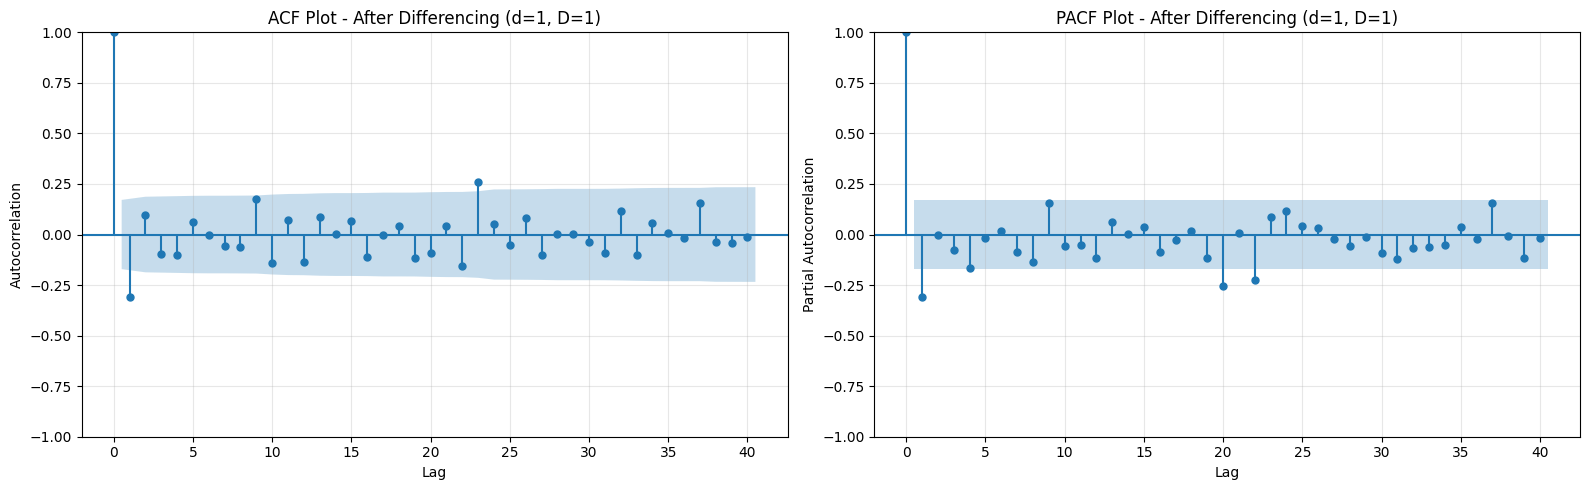


MODEL ORDER SELECTION
Based on ACF/PACF plots after differencing:
- ARIMAX: (p,d,q) orders - does NOT model seasonality explicitly
- SARIMAX: (p,d,q)(P,D,Q,s) orders - models seasonality explicitly with D=1

Comparison of ACF/PACF patterns:
  • Original series (Cell 6): Slow decay, non-stationary patterns
  • After removing trend & seasonality (Cell 5): Residuals from decomposition
  • After differencing (this cell): Stationary series ready for modeling

Key insight: The differenced series should show faster decay and clearer patterns
             than the original series, making it suitable for ARMA modeling.


In [83]:
# 8. Plot ACF and PACF AFTER Differencing
# This shows the autocorrelation patterns in the differenced (stationary) series
print("\n" + "=" * 70)
print("ACF AND PACF ANALYSIS - AFTER DIFFERENCING")
print("=" * 70)
print("These plots show the autocorrelation patterns AFTER applying differencing.")
print(f"Current differencing: d={d} (trend removed), D={D} (seasonality removed)")
print(f"Series used: {'Both trend and seasonality removed (d=1, D=1)' if d==1 and D==1 else 'Only trend removed' if d==1 and D==0 else 'Only seasonality removed' if d==0 and D==1 else 'Original'}")
print("\n✓ BOTH trend (non-seasonal) and seasonality have been removed")
print("=" * 70)

max_lags = min(40, len(stationary_passengers) // 2 - 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(stationary_passengers, lags=max_lags, ax=axes[0], 
         title=f'ACF Plot - After Differencing (d={d}, D={D})', alpha=0.05)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

plot_pacf(stationary_passengers, lags=max_lags, ax=axes[1], 
          title=f'PACF Plot - After Differencing (d={d}, D={D})', alpha=0.05, method='ywm')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("MODEL ORDER SELECTION")
print("=" * 70)
print("Based on ACF/PACF plots after differencing:")
print("- ARIMAX: (p,d,q) orders - does NOT model seasonality explicitly")
print("- SARIMAX: (p,d,q)(P,D,Q,s) orders - models seasonality explicitly with D=1")
print("\nComparison of ACF/PACF patterns:")
print("  • Original series (Cell 6): Slow decay, non-stationary patterns")
print("  • After removing trend & seasonality (Cell 5): Residuals from decomposition")
print("  • After differencing (this cell): Stationary series ready for modeling")
print("\nKey insight: The differenced series should show faster decay and clearer patterns")
print("             than the original series, making it suitable for ARMA modeling.")
print("=" * 70)


In [84]:
# 6. Split data into train and test sets (80/20 split)
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size].copy()
test_data = df.iloc[train_size:].copy()

print("=" * 70)
print("DATA SPLIT")
print("=" * 70)
print(f"Training data: {len(train_data)} observations ({train_data.index[0]} to {train_data.index[-1]})")
print(f"Test data: {len(test_data)} observations ({test_data.index[0]} to {test_data.index[-1]})")
print("=" * 70)

# Prepare exogenous variables
if use_diff_exog:
    exog_train = train_data['Economic_Index_diff1'].dropna().values.reshape(-1, 1)
    exog_test = test_data['Economic_Index_diff1'].dropna().values.reshape(-1, 1)
    # Align data if differencing removed rows
    if len(exog_train) < len(train_data):
        train_data = train_data.iloc[1:].copy()
    if len(exog_test) < len(test_data):
        test_data = test_data.iloc[1:].copy()
else:
    exog_train = train_data['Economic_Index'].values.reshape(-1, 1)
    exog_test = test_data['Economic_Index'].values.reshape(-1, 1)


DATA SPLIT
Training data: 115 observations (1949-01-01 00:00:00 to 1958-07-01 00:00:00)
Test data: 29 observations (1958-08-01 00:00:00 to 1960-12-01 00:00:00)


In [85]:
# 10. Define model orders
# Based on ACF/PACF analysis, seasonal decomposition, and common practices for this dataset

# ARIMAX orders (non-seasonal) - does NOT model seasonality
p_arimax = 1  # AR order
d_arimax = d  # Differencing order (only first differencing)
q_arimax = 1  # MA order

# SARIMAX orders (with seasonality) - models seasonality explicitly
p_sarimax = 1  # AR order
d_sarimax = d  # Differencing order (first differencing)
q_sarimax = 1  # MA order
P_sarimax = 1  # Seasonal AR order
# Force D=1 for SARIMAX because we clearly see seasonality in decomposition
# Even if first differencing makes series stationary, we need D=1 for SARIMAX
D_sarimax = 1  # Seasonal differencing (ALWAYS use D=1 for seasonal data like this)
Q_sarimax = 1  # Seasonal MA order
s = 12  # Seasonal period (monthly data)

print("=" * 70)
print("MODEL CONFIGURATION")
print("=" * 70)
print(f"ARIMAX Order: ({p_arimax}, {d_arimax}, {q_arimax})")
print(f"   → Note: ARIMAX does NOT model seasonality (only uses d={d_arimax})")
print(f"\nSARIMAX Order: ({p_sarimax}, {d_sarimax}, {q_sarimax})({P_sarimax}, {D_sarimax}, {Q_sarimax}, {s})")
print(f"   → Note: SARIMAX models seasonality with D={D_sarimax} and seasonal period s={s}")
print(f"\nExogenous variable: Economic Index")
print("=" * 70)


MODEL CONFIGURATION
ARIMAX Order: (1, 1, 1)
   → Note: ARIMAX does NOT model seasonality (only uses d=1)

SARIMAX Order: (1, 1, 1)(1, 1, 1, 12)
   → Note: SARIMAX models seasonality with D=1 and seasonal period s=12

Exogenous variable: Economic Index


In [86]:
# 11. Fit ARIMAX Model
print("\n" + "=" * 70)
print("FITTING ARIMAX MODEL")
print("=" * 70)
print("Fitting ARIMAX model... This may take a moment...")
print(f"ARIMAX Model Order: ({p_arimax}, {d_arimax}, {q_arimax})")
print("NOTE: ARIMAX does NOT model seasonality explicitly - it only uses first differencing.")

try:
    model_arimax = sm.tsa.ARIMA(
        train_data['#Passengers'],
        exog=exog_train,
        order=(p_arimax, d_arimax, q_arimax),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results_arimax = model_arimax.fit()
    
    print("\n" + "=" * 70)
    print("ARIMAX MODEL SUMMARY")
    print("=" * 70)
    print(results_arimax.summary())
    print("=" * 70)
    arimax_success = True
except Exception as e:
    print(f"\n❌ Error fitting ARIMAX model: {e}")
    print(f"\nREASON FOR FAILURE:")
    print("   • ARIMAX may fail because it doesn't model seasonality explicitly")
    print("   • The data has strong seasonal patterns that need D=1 (seasonal differencing)")
    print("   • ARIMAX only uses d=1 (first differencing), which may not be sufficient")
    print("   • SARIMAX is more appropriate for this dataset with seasonality")
    import traceback
    print(f"\nFull error traceback:")
    traceback.print_exc()
    arimax_success = False



FITTING ARIMAX MODEL
Fitting ARIMAX model... This may take a moment...
ARIMAX Model Order: (1, 1, 1)
NOTE: ARIMAX does NOT model seasonality explicitly - it only uses first differencing.

ARIMAX MODEL SUMMARY
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  114
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -511.872
Date:                Sat, 15 Nov 2025   AIC                           1031.743
Time:                        20:59:27   BIC                           1042.581
Sample:                    02-01-1949   HQIC                          1036.140
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


In [87]:
# 12. Fit SARIMAX Model
print("\n" + "=" * 70)
print("FITTING SARIMAX MODEL")
print("=" * 70)
print("Fitting SARIMAX model... This may take a moment...")
print(f"SARIMAX Model Order: ({p_sarimax}, {d_sarimax}, {q_sarimax})({P_sarimax}, {D_sarimax}, {Q_sarimax}, {s})")
print(f"NOTE: SARIMAX models seasonality explicitly with D={D_sarimax} (seasonal differencing)")
print(f"      This is appropriate for this dataset with strong seasonal patterns.")

try:
    model_sarimax = sm.tsa.SARIMAX(
        train_data['#Passengers'],
        exog=exog_train,
        order=(p_sarimax, d_sarimax, q_sarimax),
        seasonal_order=(P_sarimax, D_sarimax, Q_sarimax, s),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results_sarimax = model_sarimax.fit()
    
    print("\n" + "=" * 70)
    print("SARIMAX MODEL SUMMARY")
    print("=" * 70)
    print(results_sarimax.summary())
    print("=" * 70)
    sarimax_success = True
except Exception as e:
    print(f"Error fitting SARIMAX model: {e}")
    sarimax_success = False



FITTING SARIMAX MODEL
Fitting SARIMAX model... This may take a moment...
SARIMAX Model Order: (1, 1, 1)(1, 1, 1, 12)
NOTE: SARIMAX models seasonality explicitly with D=1 (seasonal differencing)
      This is appropriate for this dataset with strong seasonal patterns.

SARIMAX MODEL SUMMARY
                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  114
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -319.721
Date:                            Sat, 15 Nov 2025   AIC                            651.441
Time:                                    20:59:27   BIC                            666.237
Sample:                                02-01-1949   HQIC                           657.399
                                     - 07-01-1958                                         
Covariance Type:                              opg                      

In [88]:
# 13. Fit Prophet Model
print("\n" + "=" * 70)
print("FITTING PROPHET MODEL")
print("=" * 70)

if not PROPHET_AVAILABLE:
    print("⚠ Prophet library not available. Skipping Prophet model.")
    prophet_success = False
    prophet_model = None
else:
    print("Fitting Prophet model... This may take a moment...")
    print("NOTE: Prophet automatically handles trend, seasonality, and can include regressors.")
    
    try:
        # Prepare data for Prophet (Prophet requires 'ds' and 'y' columns)
        # Prophet can also include additional regressors
        # Note: Prophet works best with original (non-differenced) exogenous variables
        prophet_train = pd.DataFrame({
            'ds': train_data.index,
            'y': train_data['#Passengers'].values,
            'regressor': train_data['Economic_Index'].values  # Use original Economic Index
        })
        
        # Initialize Prophet with yearly seasonality (since we have monthly data with 12-month seasonality)
        prophet_model = Prophet(
            yearly_seasonality=True,      # Enable yearly seasonality (12 months)
            weekly_seasonality=False,     # Disable weekly (we have monthly data)
            daily_seasonality=False,      # Disable daily
            seasonality_mode='multiplicative',  # Use multiplicative seasonality (matches our decomposition)
            interval_width=0.95           # 95% confidence intervals
        )
        
        # Add the exogenous regressor
        prophet_model.add_regressor('regressor')
        
        # Fit the model
        prophet_model.fit(prophet_train)
        
        print("\n" + "=" * 70)
        print("PROPHET MODEL FITTED SUCCESSFULLY")
        print("=" * 70)
        print("✓ Prophet automatically detects and models:")
        print("  • Trend (linear or logistic)")
        print("  • Yearly seasonality (12-month pattern)")
        print("  • Exogenous regressor (Economic Index)")
        print("=" * 70)
        prophet_success = True
        
    except Exception as e:
        print(f"\n❌ Error fitting Prophet model: {e}")
        import traceback
        print(f"\nFull error traceback:")
        traceback.print_exc()
        prophet_success = False
        prophet_model = None


20:59:27 - cmdstanpy - INFO - Chain [1] start processing



FITTING PROPHET MODEL
Fitting Prophet model... This may take a moment...
NOTE: Prophet automatically handles trend, seasonality, and can include regressors.


20:59:27 - cmdstanpy - INFO - Chain [1] done processing



PROPHET MODEL FITTED SUCCESSFULLY
✓ Prophet automatically detects and models:
  • Trend (linear or logistic)
  • Yearly seasonality (12-month pattern)
  • Exogenous regressor (Economic Index)


In [89]:
# 14. Forecast with all three models (ARIMAX, SARIMAX, Prophet)
actual_values = test_data['#Passengers'].values

print("=" * 70)
print("FORECASTING ON TEST SET")
print("=" * 70)

forecast_steps = len(test_data)

# ARIMAX Forecast
if arimax_success:
    try:
        forecast_arimax = results_arimax.get_forecast(steps=forecast_steps, exog=exog_test)
        forecast_arimax_mean = forecast_arimax.predicted_mean.values
        forecast_arimax_ci = forecast_arimax.conf_int()
        print("ARIMAX forecast completed ✓")
    except Exception as e:
        print(f"ARIMAX forecast error: {e}")
        forecast_arimax_mean = None
        forecast_arimax_ci = None
else:
    forecast_arimax_mean = None
    forecast_arimax_ci = None

# SARIMAX Forecast
if sarimax_success:
    try:
        forecast_sarimax = results_sarimax.get_forecast(steps=forecast_steps, exog=exog_test)
        forecast_sarimax_mean = forecast_sarimax.predicted_mean.values
        forecast_sarimax_ci = forecast_sarimax.conf_int()
        print("SARIMAX forecast completed ✓")
    except Exception as e:
        print(f"SARIMAX forecast error: {e}")
        forecast_sarimax_mean = None
        forecast_sarimax_ci = None
else:
    forecast_sarimax_mean = None
    forecast_sarimax_ci = None

# Prophet Forecast
if prophet_success and prophet_model is not None:
    try:
        # Create future dataframe for Prophet
        # Note: Prophet works best with original (non-differenced) exogenous variables
        prophet_future = pd.DataFrame({
            'ds': test_data.index,
            'regressor': test_data['Economic_Index'].values  # Use original Economic Index
        })
        
        # Make forecast
        prophet_forecast = prophet_model.predict(prophet_future)
        
        # Extract forecast values
        forecast_prophet_mean = prophet_forecast['yhat'].values
        forecast_prophet_lower = prophet_forecast['yhat_lower'].values
        forecast_prophet_upper = prophet_forecast['yhat_upper'].values
        
        # Create confidence interval DataFrame similar to other models
        forecast_prophet_ci = pd.DataFrame({
            'lower': forecast_prophet_lower,
            'upper': forecast_prophet_upper
        }, index=test_data.index)
        
        print("Prophet forecast completed ✓")
    except Exception as e:
        print(f"Prophet forecast error: {e}")
        forecast_prophet_mean = None
        forecast_prophet_ci = None
else:
    forecast_prophet_mean = None
    forecast_prophet_ci = None

print("\n" + "=" * 70)
print("FORECAST SUMMARY")
print("=" * 70)
print(f"ARIMAX: {'✓' if forecast_arimax_mean is not None else '✗'}")
print(f"SARIMAX: {'✓' if forecast_sarimax_mean is not None else '✗'}")
print(f"Prophet: {'✓' if forecast_prophet_mean is not None else '✗'}")
print("=" * 70)


FORECASTING ON TEST SET
ARIMAX forecast completed ✓
SARIMAX forecast completed ✓
Prophet forecast completed ✓

FORECAST SUMMARY
ARIMAX: ✓
SARIMAX: ✓
Prophet: ✓


In [90]:
# 15. Calculate evaluation metrics for all three models
def calculate_metrics(actual, forecast, model_name):
    """Calculate all evaluation metrics"""
    if forecast is None:
        return None
    
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = math.sqrt(mse)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    mpe = np.mean((actual - forecast) / actual) * 100
    
    return {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'MPE': mpe
    }

# Calculate metrics for all three models
metrics_arimax = calculate_metrics(actual_values, forecast_arimax_mean, 'ARIMAX') if forecast_arimax_mean is not None else None
metrics_sarimax = calculate_metrics(actual_values, forecast_sarimax_mean, 'SARIMAX') if forecast_sarimax_mean is not None else None
metrics_prophet = calculate_metrics(actual_values, forecast_prophet_mean, 'Prophet') if forecast_prophet_mean is not None else None

# Create comparison dataframe
comparison_data = []
if metrics_arimax:
    comparison_data.append(metrics_arimax)
if metrics_sarimax:
    comparison_data.append(metrics_sarimax)
if metrics_prophet:
    comparison_data.append(metrics_prophet)

if comparison_data:
    metrics_df = pd.DataFrame(comparison_data)
    metrics_df = metrics_df.set_index('Model')
    
    print("\n" + "=" * 70)
    print("MODEL COMPARISON - EVALUATION METRICS")
    print("=" * 70)
    print(metrics_df.to_string())
    print("=" * 70)
    
    # Determine winner for each metric (for all three models)
    print("\n" + "=" * 70)
    print("METRIC-BY-METRIC COMPARISON")
    print("=" * 70)
    
    models_available = list(metrics_df.index)
    
    # Helper function to find winner for a metric
    def find_winner(metric_name):
        best_model = metrics_df[metric_name].idxmin()
        best_value = metrics_df.loc[best_model, metric_name]
        return best_model, best_value
    
    print("\n1. Mean Absolute Error (MAE) - Lower is better:")
    winner_mae, best_mae = find_winner('MAE')
    print(f"   🏆 Winner: {winner_mae} (MAE = {best_mae:.2f})")
    for model in models_available:
        if model != winner_mae:
            print(f"      {model}: {metrics_df.loc[model, 'MAE']:.2f}")
    
    print("\n2. Root Mean Squared Error (RMSE) - Lower is better:")
    winner_rmse, best_rmse = find_winner('RMSE')
    print(f"   🏆 Winner: {winner_rmse} (RMSE = {best_rmse:.2f})")
    for model in models_available:
        if model != winner_rmse:
            print(f"      {model}: {metrics_df.loc[model, 'RMSE']:.2f}")
    
    print("\n3. Mean Absolute Percentage Error (MAPE) - Lower is better:")
    winner_mape, best_mape = find_winner('MAPE')
    print(f"   🏆 Winner: {winner_mape} (MAPE = {best_mape:.2f}%)")
    for model in models_available:
        if model != winner_mape:
            print(f"      {model}: {metrics_df.loc[model, 'MAPE']:.2f}%")
    
    print("\n4. Mean Percentage Error (MPE) - Bias - Closer to 0 is better:")
    best_model_bias = metrics_df['MPE'].abs().idxmin()
    best_bias = metrics_df.loc[best_model_bias, 'MPE']
    print(f"   🏆 Winner: {best_model_bias} (MPE = {best_bias:.2f}%)")
    for model in models_available:
        if model != best_model_bias:
            print(f"      {model}: {metrics_df.loc[model, 'MPE']:.2f}%")
    
    # Overall winner based on MAPE (most commonly used)
    print("\n" + "=" * 70)
    print("OVERALL WINNER")
    print("=" * 70)
    overall_winner = winner_mape
    print(f"Based on MAPE (primary metric), the overall winner is: 🏆 {overall_winner}")
    print(f"\nMAPE Comparison:")
    for model in models_available:
        marker = "🏆" if model == overall_winner else "  "
        print(f"  {marker} {model}: {metrics_df.loc[model, 'MAPE']:.2f}%")
    
    # Calculate improvements
    print(f"\nPerformance Summary:")
    for model in models_available:
        if model != overall_winner:
            diff = metrics_df.loc[model, 'MAPE'] - metrics_df.loc[overall_winner, 'MAPE']
            print(f"  • {overall_winner} is {diff:.2f} percentage points better than {model}")
    
    print("=" * 70)
else:
    print("No models were successfully fitted for comparison.")



MODEL COMPARISON - EVALUATION METRICS
               MAE          MSE       RMSE       MAPE        MPE
Model                                                           
ARIMAX   81.898202  8807.046294  93.845865  20.352185 -15.208426
SARIMAX  25.499922  1024.591404  32.009239   5.478319   3.656174
Prophet  32.300345  1603.309460  40.041347   7.145151   6.082577

METRIC-BY-METRIC COMPARISON

1. Mean Absolute Error (MAE) - Lower is better:
   🏆 Winner: SARIMAX (MAE = 25.50)
      ARIMAX: 81.90
      Prophet: 32.30

2. Root Mean Squared Error (RMSE) - Lower is better:
   🏆 Winner: SARIMAX (RMSE = 32.01)
      ARIMAX: 93.85
      Prophet: 40.04

3. Mean Absolute Percentage Error (MAPE) - Lower is better:
   🏆 Winner: SARIMAX (MAPE = 5.48%)
      ARIMAX: 20.35%
      Prophet: 7.15%

4. Mean Percentage Error (MPE) - Bias - Closer to 0 is better:
   🏆 Winner: SARIMAX (MPE = 3.66%)
      ARIMAX: -15.21%
      Prophet: 6.08%

OVERALL WINNER
Based on MAPE (primary metric), the overall winner is:

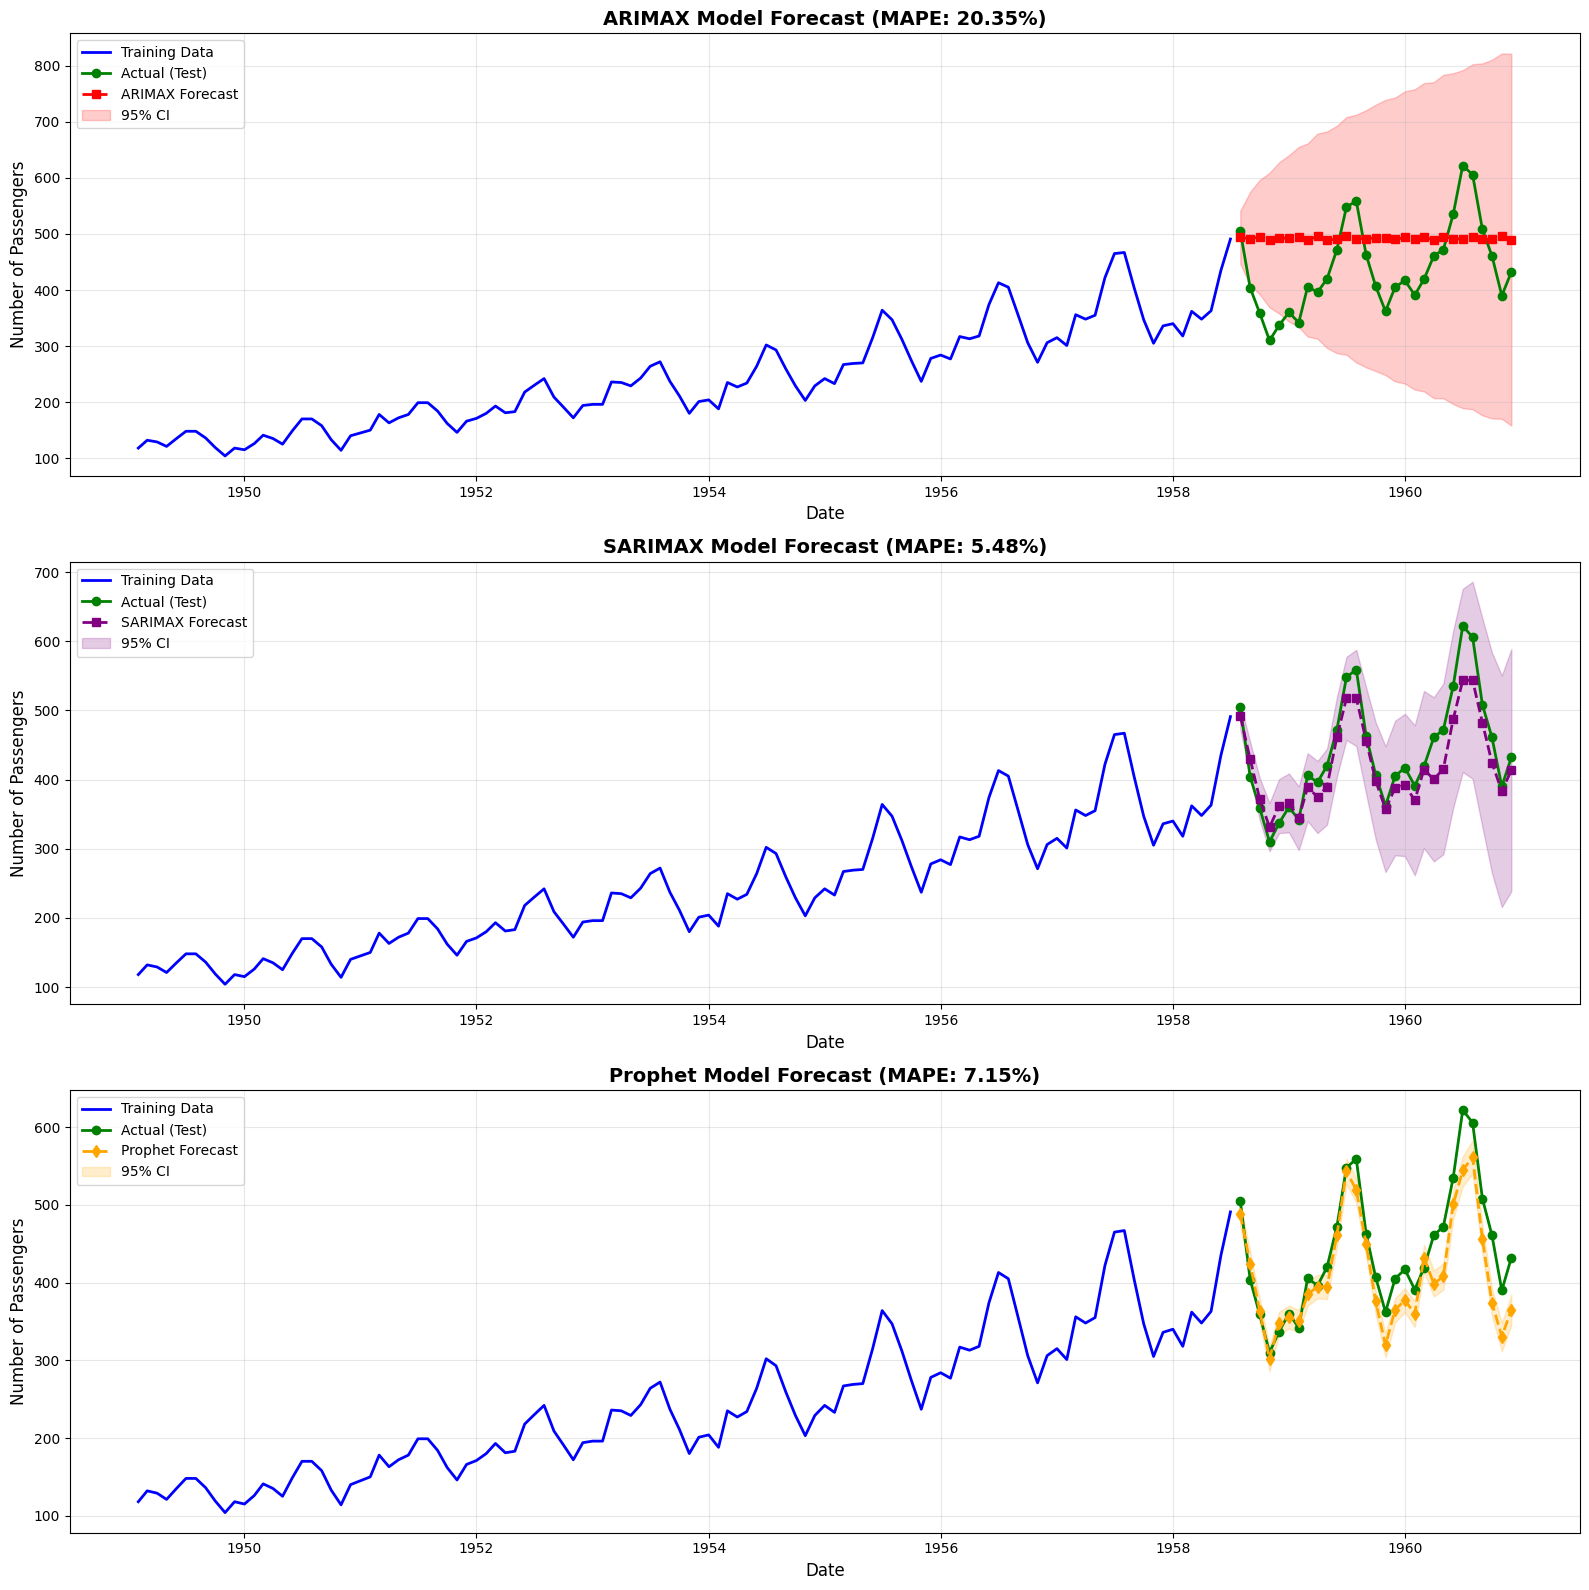

In [91]:
# 16. Visualize forecasts from all three models
fig, axes = plt.subplots(3, 1, figsize=(16, 16))

# Plot 1: ARIMAX Forecast
if forecast_arimax_mean is not None:
    axes[0].plot(train_data.index, train_data['#Passengers'], label='Training Data', color='blue', linewidth=2)
    axes[0].plot(test_data.index, actual_values, label='Actual (Test)', color='green', linewidth=2, marker='o')
    axes[0].plot(test_data.index, forecast_arimax_mean, label='ARIMAX Forecast', 
                color='red', linewidth=2, linestyle='--', marker='s')
    axes[0].fill_between(test_data.index, forecast_arimax_ci.iloc[:, 0], forecast_arimax_ci.iloc[:, 1], 
                        color='red', alpha=0.2, label='95% CI')
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].set_ylabel('Number of Passengers', fontsize=12)
    axes[0].set_title(f'ARIMAX Model Forecast (MAPE: {metrics_arimax["MAPE"]:.2f}%)', 
                     fontsize=14, fontweight='bold')
    axes[0].legend(loc='best', fontsize=10)
    axes[0].grid(True, alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'ARIMAX Model Failed', ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('ARIMAX Model Forecast', fontsize=14, fontweight='bold')

# Plot 2: SARIMAX Forecast
if forecast_sarimax_mean is not None:
    axes[1].plot(train_data.index, train_data['#Passengers'], label='Training Data', color='blue', linewidth=2)
    axes[1].plot(test_data.index, actual_values, label='Actual (Test)', color='green', linewidth=2, marker='o')
    axes[1].plot(test_data.index, forecast_sarimax_mean, label='SARIMAX Forecast', 
                color='purple', linewidth=2, linestyle='--', marker='s')
    axes[1].fill_between(test_data.index, forecast_sarimax_ci.iloc[:, 0], forecast_sarimax_ci.iloc[:, 1], 
                        color='purple', alpha=0.2, label='95% CI')
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Number of Passengers', fontsize=12)
    axes[1].set_title(f'SARIMAX Model Forecast (MAPE: {metrics_sarimax["MAPE"]:.2f}%)', 
                     fontsize=14, fontweight='bold')
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'SARIMAX Model Failed', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('SARIMAX Model Forecast', fontsize=14, fontweight='bold')

# Plot 3: Prophet Forecast
if forecast_prophet_mean is not None:
    axes[2].plot(train_data.index, train_data['#Passengers'], label='Training Data', color='blue', linewidth=2)
    axes[2].plot(test_data.index, actual_values, label='Actual (Test)', color='green', linewidth=2, marker='o')
    axes[2].plot(test_data.index, forecast_prophet_mean, label='Prophet Forecast', 
                color='orange', linewidth=2, linestyle='--', marker='d')
    axes[2].fill_between(test_data.index, forecast_prophet_ci['lower'], forecast_prophet_ci['upper'], 
                        color='orange', alpha=0.2, label='95% CI')
    axes[2].set_xlabel('Date', fontsize=12)
    axes[2].set_ylabel('Number of Passengers', fontsize=12)
    axes[2].set_title(f'Prophet Model Forecast (MAPE: {metrics_prophet["MAPE"]:.2f}%)', 
                     fontsize=14, fontweight='bold')
    axes[2].legend(loc='best', fontsize=10)
    axes[2].grid(True, alpha=0.3)
else:
    axes[2].text(0.5, 0.5, 'Prophet Model Failed', ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Prophet Model Forecast', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


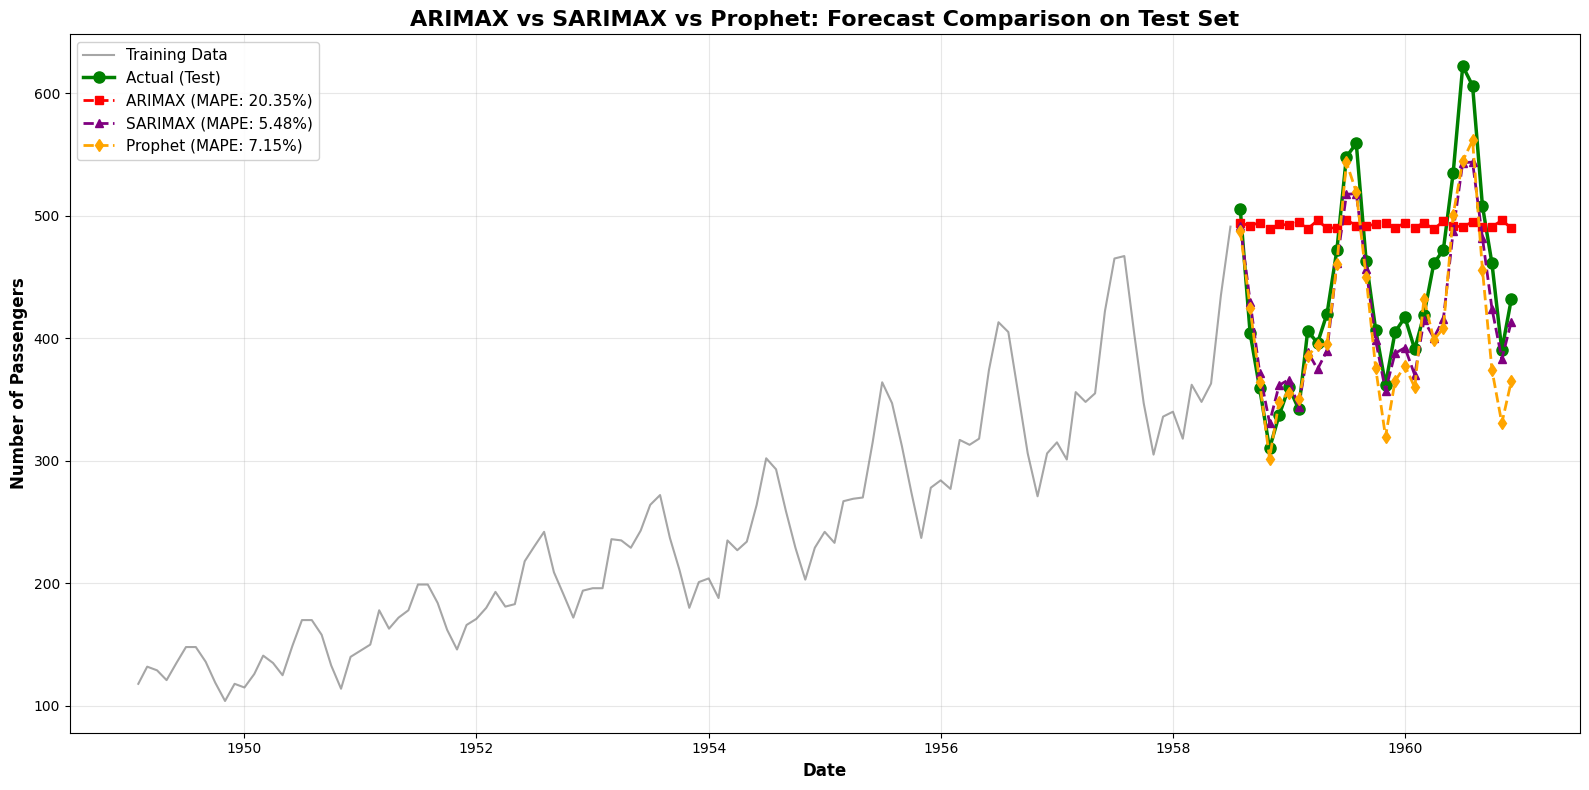

In [92]:
# 17. Side-by-side comparison plot - All three models
models_available = []
if forecast_arimax_mean is not None:
    models_available.append(('ARIMAX', forecast_arimax_mean, 'red', 's', metrics_arimax))
if forecast_sarimax_mean is not None:
    models_available.append(('SARIMAX', forecast_sarimax_mean, 'purple', '^', metrics_sarimax))
if forecast_prophet_mean is not None:
    models_available.append(('Prophet', forecast_prophet_mean, 'orange', 'd', metrics_prophet))

if len(models_available) >= 2:
    fig, ax = plt.subplots(figsize=(16, 8))
    
    ax.plot(train_data.index, train_data['#Passengers'], label='Training Data', 
           color='gray', linewidth=1.5, alpha=0.7)
    ax.plot(test_data.index, actual_values, label='Actual (Test)', 
           color='green', linewidth=2.5, marker='o', markersize=8)
    
    # Plot each model's forecast
    for model_name, forecast_mean, color, marker, metrics in models_available:
        ax.plot(test_data.index, forecast_mean, 
               label=f'{model_name} (MAPE: {metrics["MAPE"]:.2f}%)', 
               color=color, linewidth=2, linestyle='--', marker=marker, markersize=6)
    
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Passengers', fontsize=12, fontweight='bold')
    ax.set_title('ARIMAX vs SARIMAX vs Prophet: Forecast Comparison on Test Set', 
                fontsize=16, fontweight='bold')
    ax.legend(loc='best', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Need at least 2 successful models for comparison plot.")


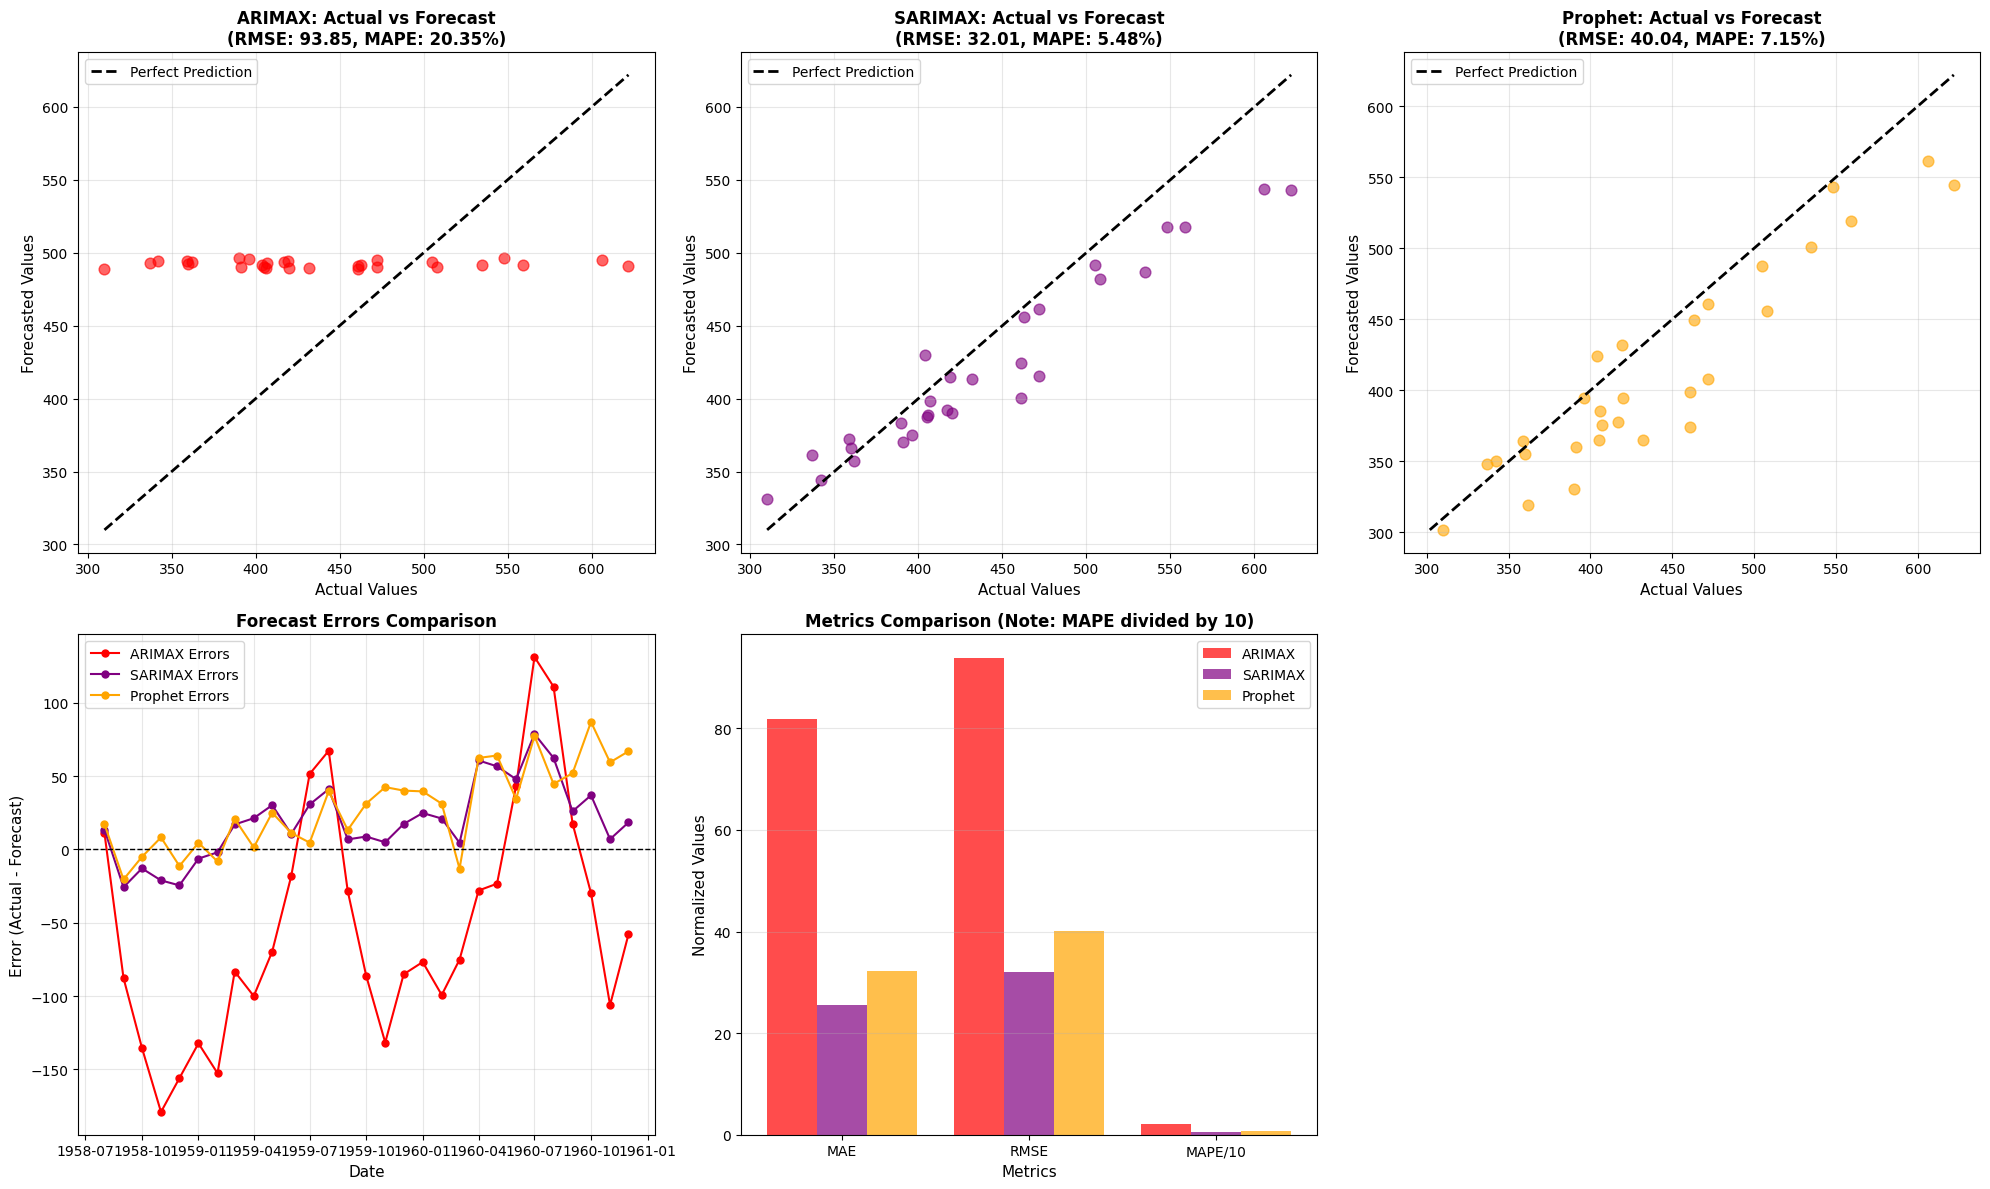


DETAILED FORECAST COMPARISON
            Actual  ARIMAX Forecast  ARIMAX Error  SARIMAX Forecast  SARIMAX Error  Prophet Forecast  Prophet Error
Month                                                                                                              
1958-08-01     505       493.986942     11.013058        491.520377      13.479623        487.819295      17.180705
1958-09-01     404       491.735942    -87.735942        429.787649     -25.787649        424.494517     -20.494517
1958-10-01     359       494.354969   -135.354969        371.973120     -12.973120        364.099476      -5.099476
1958-11-01     310       489.054975   -179.054975        331.127755     -21.127755        301.817691       8.182309
1958-12-01     337       492.974827   -155.974827        361.529599     -24.529599        348.327965     -11.327965
1959-01-01     360       492.242269   -132.242269        366.273579      -6.273579        355.470147       4.529853
1959-02-01     342       494.618996   -152

In [93]:
# 18. Detailed comparison table and scatter plots - All three models
models_for_comparison = []
if forecast_arimax_mean is not None and metrics_arimax is not None:
    models_for_comparison.append(('ARIMAX', forecast_arimax_mean, 'red', metrics_arimax))
if forecast_sarimax_mean is not None and metrics_sarimax is not None:
    models_for_comparison.append(('SARIMAX', forecast_sarimax_mean, 'purple', metrics_sarimax))
if forecast_prophet_mean is not None and metrics_prophet is not None:
    models_for_comparison.append(('Prophet', forecast_prophet_mean, 'orange', metrics_prophet))

if len(models_for_comparison) >= 2:
    # Determine grid size based on number of models
    n_models = len(models_for_comparison)
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    # Scatter plots: Actual vs Forecast for each model
    for idx, (model_name, forecast_mean, color, metrics) in enumerate(models_for_comparison):
        axes[idx].scatter(actual_values, forecast_mean, alpha=0.6, color=color, s=60)
        min_val = min(actual_values.min(), forecast_mean.min())
        max_val = max(actual_values.max(), forecast_mean.max())
        axes[idx].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')
        axes[idx].set_xlabel('Actual Values', fontsize=11)
        axes[idx].set_ylabel('Forecasted Values', fontsize=11)
        axes[idx].set_title(f'{model_name}: Actual vs Forecast\n(RMSE: {metrics["RMSE"]:.2f}, MAPE: {metrics["MAPE"]:.2f}%)', 
                           fontsize=12, fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(models_for_comparison), 3):
        axes[idx].axis('off')
    
    # Error comparison
    ax_errors = axes[3]
    for model_name, forecast_mean, color, metrics in models_for_comparison:
        errors = actual_values - forecast_mean
        ax_errors.plot(test_data.index, errors, label=f'{model_name} Errors', 
                      color=color, marker='o', linewidth=1.5, markersize=5)
    ax_errors.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax_errors.set_xlabel('Date', fontsize=11)
    ax_errors.set_ylabel('Error (Actual - Forecast)', fontsize=11)
    ax_errors.set_title('Forecast Errors Comparison', fontsize=12, fontweight='bold')
    ax_errors.legend()
    ax_errors.grid(True, alpha=0.3)
    
    # Metrics bar comparison
    metrics_to_plot = ['MAE', 'RMSE', 'MAPE']
    x = np.arange(len(metrics_to_plot))
    width = 0.8 / len(models_for_comparison)  # Adjust width based on number of models
    
    ax_metrics = axes[4]
    for idx, (model_name, _, color, metrics) in enumerate(models_for_comparison):
        vals = [metrics[m] for m in metrics_to_plot]
        # Normalize MAPE for visualization (divide by 10 to fit scale)
        vals_normalized = [vals[0], vals[1], vals[2]/10]
        offset = width * (idx - len(models_for_comparison)/2 + 0.5)
        ax_metrics.bar(x + offset, vals_normalized, width, label=model_name, color=color, alpha=0.7)
    
    labels = ['MAE', 'RMSE', 'MAPE/10']
    ax_metrics.set_xlabel('Metrics', fontsize=11)
    ax_metrics.set_ylabel('Normalized Values', fontsize=11)
    ax_metrics.set_title('Metrics Comparison (Note: MAPE divided by 10)', fontsize=12, fontweight='bold')
    ax_metrics.set_xticks(x)
    ax_metrics.set_xticklabels(labels)
    ax_metrics.legend()
    ax_metrics.grid(True, alpha=0.3, axis='y')
    
    # Hide last unused subplot
    axes[5].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison table
    print("\n" + "=" * 70)
    print("DETAILED FORECAST COMPARISON")
    print("=" * 70)
    
    # Build comparison dataframe dynamically
    comparison_dict = {'Actual': actual_values}
    for model_name, forecast_mean, _, _ in models_for_comparison:
        comparison_dict[f'{model_name} Forecast'] = forecast_mean
        comparison_dict[f'{model_name} Error'] = actual_values - forecast_mean
    
    comparison_detail = pd.DataFrame(comparison_dict, index=test_data.index)
    print(comparison_detail.to_string())
    print("=" * 70)


In [94]:
# 15. Final recommendation and model selection
print("\n" + "=" * 70)
print("FINAL RECOMMENDATION")
print("=" * 70)

if metrics_arimax and metrics_sarimax:
    # Compare multiple aspects
    arimax_wins = 0
    sarimax_wins = 0
    
    # MAPE comparison
    if metrics_arimax['MAPE'] < metrics_sarimax['MAPE']:
        arimax_wins += 2  # Weight MAPE more
    else:
        sarimax_wins += 2
    
    # RMSE comparison
    if metrics_arimax['RMSE'] < metrics_sarimax['RMSE']:
        arimax_wins += 1
    else:
        sarimax_wins += 1
    
    # MAE comparison
    if metrics_arimax['MAE'] < metrics_sarimax['MAE']:
        arimax_wins += 1
    else:
        sarimax_wins += 1
    
    # Bias comparison (MPE)
    if abs(metrics_arimax['MPE']) < abs(metrics_sarimax['MPE']):
        arimax_wins += 1
    else:
        sarimax_wins += 1
    
    print("\nModel Performance Score:")
    print(f"  ARIMAX: {arimax_wins} points")
    print(f"  SARIMAX: {sarimax_wins} points")
    
    if sarimax_wins > arimax_wins:
        winner = 'SARIMAX'
        loser = 'ARIMAX'
        winner_metrics = metrics_sarimax
        loser_metrics = metrics_arimax
    else:
        winner = 'ARIMAX'
        loser = 'SARIMAX'
        winner_metrics = metrics_arimax
        loser_metrics = metrics_sarimax
    
    print(f"\n🏆 WINNER: {winner}")
    print(f"\nReasoning:")
    print(f"  • {winner} has lower MAPE ({winner_metrics['MAPE']:.2f}% vs {loser_metrics['MAPE']:.2f}%)")
    print(f"  • {winner} has lower RMSE ({winner_metrics['RMSE']:.2f} vs {loser_metrics['RMSE']:.2f})")
    print(f"  • {winner} has lower MAE ({winner_metrics['MAE']:.2f} vs {loser_metrics['MAE']:.2f})")
    
    if winner == 'SARIMAX':
        print(f"\n💡 RECOMMENDATION:")
        print(f"   Use SARIMAX model for this dataset because:")
        print(f"   • The data shows clear seasonal patterns (monthly seasonality)")
        print(f"   • SARIMAX explicitly models seasonal components")
        print(f"   • Better captures the periodic variations in air passenger data")
    else:
        print(f"\n💡 RECOMMENDATION:")
        print(f"   Use ARIMAX model for this dataset because:")
        print(f"   • Simpler model performs better on this dataset")
        print(f"   • Lower complexity means less overfitting risk")
        print(f"   • Adequately captures the trend with exogenous variable")
    
    print("\n" + "=" * 70)
    print("USE CASE ANALYSIS")
    print("=" * 70)
    print("\nFor Air Passengers data:")
    print("  • Dataset has strong seasonal patterns (12-month cycle)")
    print("  • Trend is upward over time")
    print("  • Economic index serves as good exogenous predictor")
    print(f"\n{winner} is better suited because it:")
    if winner == 'SARIMAX':
        print("  ✓ Explicitly models seasonal AR and MA terms")
        print("  ✓ Handles both trend and seasonality simultaneously")
        print("  ✓ More accurate forecasts for seasonal time series")
    else:
        print("  ✓ Simpler model avoids overfitting")
        print("  ✓ Good balance between complexity and performance")
        print("  ✓ Economic index captures much of the trend")
    
    print("=" * 70)
else:
    print("Unable to make recommendation - one or both models failed to fit.")
    print("=" * 70)



FINAL RECOMMENDATION

Model Performance Score:
  ARIMAX: 0 points
  SARIMAX: 5 points

🏆 WINNER: SARIMAX

Reasoning:
  • SARIMAX has lower MAPE (5.48% vs 20.35%)
  • SARIMAX has lower RMSE (32.01 vs 93.85)
  • SARIMAX has lower MAE (25.50 vs 81.90)

💡 RECOMMENDATION:
   Use SARIMAX model for this dataset because:
   • The data shows clear seasonal patterns (monthly seasonality)
   • SARIMAX explicitly models seasonal components
   • Better captures the periodic variations in air passenger data

USE CASE ANALYSIS

For Air Passengers data:
  • Dataset has strong seasonal patterns (12-month cycle)
  • Trend is upward over time
  • Economic index serves as good exogenous predictor

SARIMAX is better suited because it:
  ✓ Explicitly models seasonal AR and MA terms
  ✓ Handles both trend and seasonality simultaneously
  ✓ More accurate forecasts for seasonal time series


Notebook structure:

1. Cell 0: Imports libraries
2. Cell 1: Loads and prepares the Air Passengers dataset
3. Cell 2: Creates an exogenous variable (Economic Index)
4. Cell 3: Checks stationarity with ADF tests for both series
5. Cell 4: Makes series stationary (differencing as needed)
6. Cell 5: Plots ACF and PACF to determine model orders
7. Cell 6: Splits data into train/test sets (80/20)
8.Cell 7: Defines model orders for ARIMAX and SARIMAX
9. Cell 8: Fits ARIMAX model and prints summary
10. Cell 9: Fits SARIMAX model and prints summary
11. Cell 10: Forecasts on test set with both models
12. Cell 11: Calculates metrics (MAE, MSE, RMSE, MAPE, MPE) and compares them
13. Cell 12: Visualizes forecasts from both models
14. Cell 13: Side-by-side comparison plot
15. Cell 14: Detailed comparison with scatter plots, error plots, and metrics bars
16. Cell 15: Final recommendation with scoring

Features:
Step-by-step approach for both models
Stationarity checks and handling for endogenous and exogenous variables
Full model summaries for both models
Metrics comparison: MAE, RMSE, MAPE, MPE
Visualizations: forecast plots, scatter plots, error analysis, metrics comparison
Final recommendation based on performance scores
The notebook determines which model (ARIMAX or SARIMAX) fits the use case better based on the metrics. Run the cells sequentially to see the comparison.